In [ ]:
import matplotlib.pyplot as plt

def roi_center(magnitude_spectrum, zoom_factor=0.5):
    height, width = magnitude_spectrum.shape

    zoom_height = int(height * zoom_factor)
    zoom_width = int(width * zoom_factor)
    top_left_x = (width - zoom_width) // 2
    top_left_y = (height - zoom_height) // 2

    # Define the zoomed-in region
    zoomed_region = magnitude_spectrum[top_left_y:top_left_y+zoom_height, top_left_x:top_left_x+zoom_width]

    return zoomed_region



In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def plot_fft(image):
  # Read the image

  # Resize the image
  image = cv2.resize(image, (416, 416))

  # Compute the 2D Fourier transform
  f_transform = np.fft.fft2(image)

  # Shift the zero frequency component to the center
  f_transform_shifted = np.fft.fftshift(f_transform)

  # Compute the magnitude spectrum
  magnitude_spectrum = np.int32(20 * np.log(np.abs(f_transform_shifted)))
  threshold = (np.max(magnitude_spectrum)+np.min(magnitude_spectrum))//2
  binary_spectrum = magnitude_spectrum > threshold
  binary_spectrum = binary_spectrum.astype(np.uint8) * 255

  # Plotting
  plt.figure(figsize=(8, 4))

  plt.subplot(131), plt.imshow(image, cmap='gray')
  plt.title('Original Image'), plt.xticks([]), plt.yticks([])

  plt.subplot(132), plt.imshow(magnitude_spectrum, cmap='gray')
  plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])

  plt.subplot(133), plt.imshow(binary_spectrum, cmap='gray')
  plt.title('Binary Spectrum'), plt.xticks([]), plt.yticks([])

  plt.show()
  return magnitude_spectrum, binary_spectrum, threshold




In [ ]:
image1 = cv2.imread('/content/drive/MyDrive/Minor_project_sem6/MirrorNow_original.png', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('/content/drive/MyDrive/Minor_project_sem6/MirrorNow_cp.png', cv2.IMREAD_GRAYSCALE)

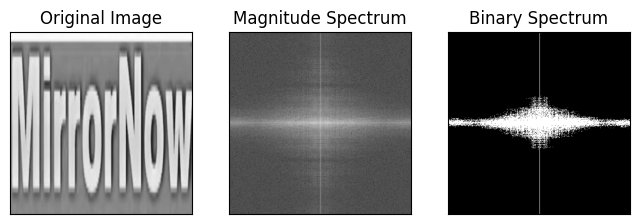

(416, 416) (416, 416) 159


In [ ]:
ms1, bs1, th1 = plot_fft(image1)
print(ms1.shape,bs1.shape,th1)

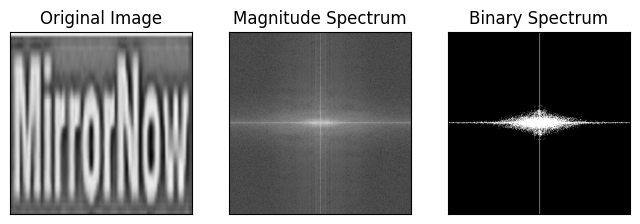

(416, 416) (416, 416) 164


In [ ]:
ms2, bs2, th2 = plot_fft(image2)
print(ms2.shape,bs2.shape,th2)

### Plotting the sectors

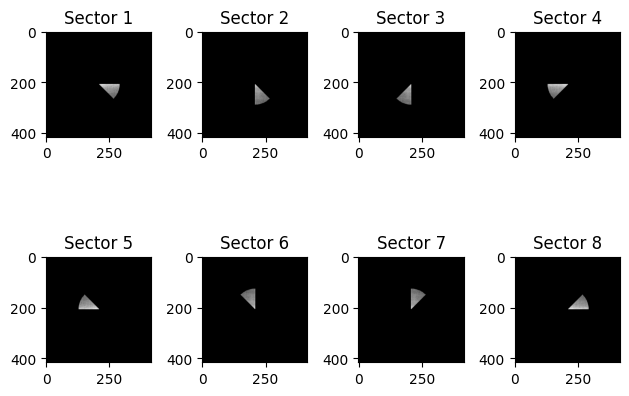

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_sector_mask(image, radius, num_sectors=8):
    center = (image.shape[1] // 2, image.shape[0] // 2)

    sector_masks = []

    for j in range(num_sectors):
        sector_mask = np.zeros_like(image, dtype=np.uint8)

        start_angle = j * 360 // num_sectors
        end_angle = (j + 1) * 360 // num_sectors

        cv2.ellipse(sector_mask, center, (radius,radius), 0, start_angle, end_angle, 255, -1)
        cv2.ellipse(sector_mask, center, (0, 0), 0, start_angle, end_angle, 0, -1)

        sector_masks.append(sector_mask)

    return sector_masks

img = cv2.imread('/content/drive/MyDrive/Minor_project_sem6/MirrorNow_original.png', cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (416, 416))

sector_masks = get_sector_mask(img,80)

# Plot the sector masks
for j, sector_mask in enumerate(sector_masks):
    sector_val = ms1.copy()
    sector_val[sector_mask == 0] = 0
    plt.subplot(2, 4, j + 1)
    plt.imshow(sector_val, cmap='gray')  # Use 'gray' colormap for binary images
    plt.title(f'Sector {j + 1}')

plt.tight_layout()
plt.show()


### track mask

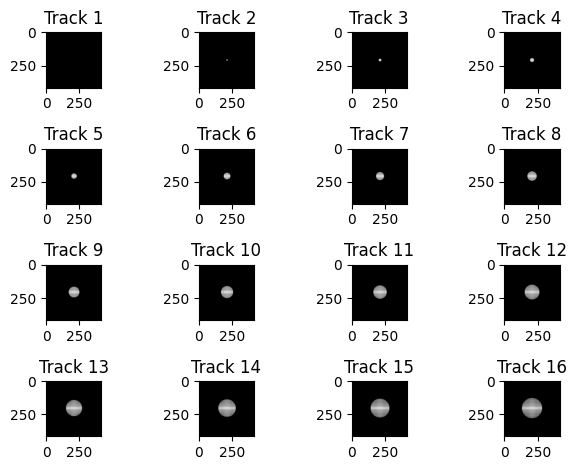

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_circular_track_mask(image,thickness=5,tracks = 16):
    center = (image.shape[1] // 2, image.shape[0] // 2)
    track_masks = []

    for j in range(0,thickness*tracks,thickness):

      # Create a black mask
      track_mask = np.zeros_like(image, dtype=np.uint8)

      # Draw the outer circle
      cv2.circle(track_mask, center, j, 255, thickness=-1)

      # Draw the inner circle
      cv2.circle(track_mask, center, 0, 0, thickness=-1)
      track_masks.append(track_mask)
    return track_masks

img = cv2.imread('/content/drive/MyDrive/Minor_project_sem6/MirrorNow_original.png', cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (416, 416))


track_masks = get_circular_track_mask(img)

# Plot the sector masks
for j, track_mask in enumerate(track_masks):
    track_val = ms1.copy()
    track_val[track_mask == 0] = 0
    plt.subplot(4, 4, j + 1)
    plt.imshow(track_val, cmap='gray')  # Use 'gray' colormap for binary images
    plt.title(f'Track {j + 1}')

plt.tight_layout()
plt.show()



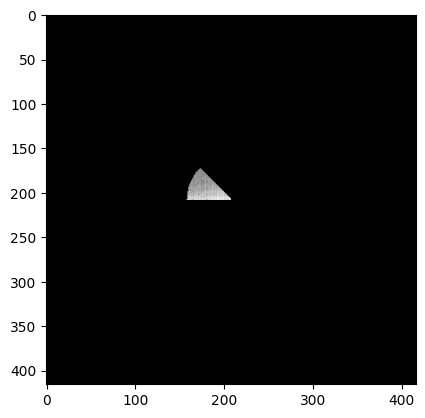

In [ ]:
def merged_mask(sector_mask,track_mask):
  return cv2.bitwise_and(sector_mask,track_mask)

final_mask = merged_mask(sector_masks[4],track_masks[10])
sec_track_val = ms1.copy()
sec_track_val[final_mask == 0] = 0
plt.imshow(sec_track_val, cmap='gray')
plt.show()

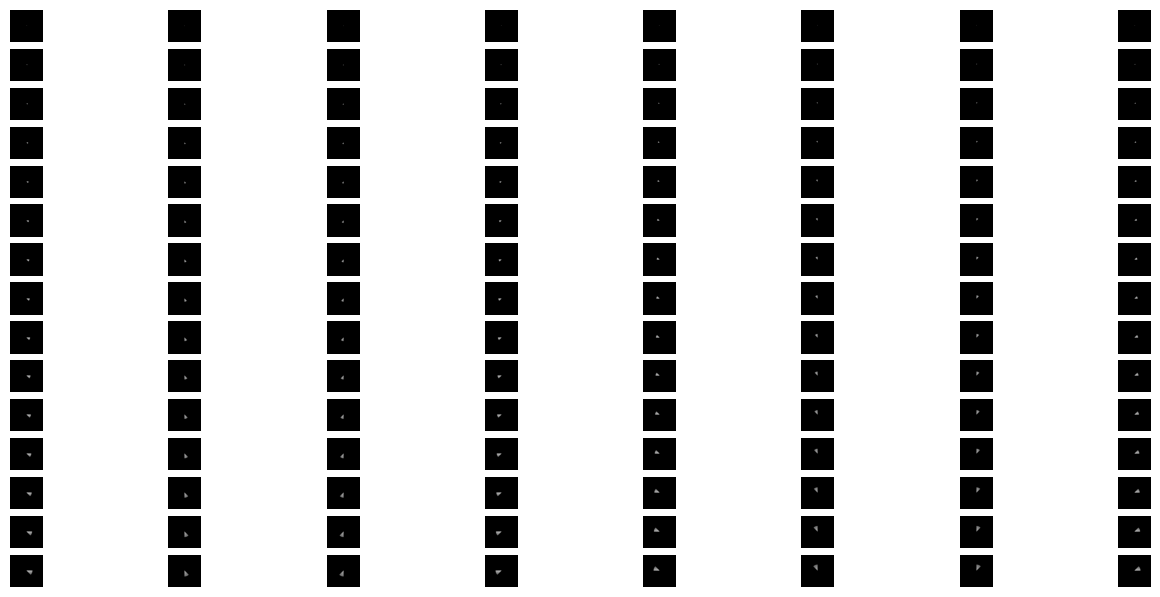

Image 1 :  [0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4] 159


In [ ]:
def analyze_coefficients(img, thickness=5, tracks=16):
    img = cv2.resize(img, (416, 416))
    center = (img.shape[1] // 2, img.shape[0] // 2)
    # fourier transform
    f_transform = np.fft.fft2(img)
    f_shift = np.fft.fftshift(f_transform)
    magnitude_spectrum = np.int32(20 * np.log(np.abs(f_shift)))

    # sector mask and track mask
    sector_masks = get_sector_mask(img,80)
    track_masks = get_circular_track_mask(img)

    TSP, TBP = [], []

    threshold = ((np.max(magnitude_spectrum)+np.min(magnitude_spectrum))//2)
    # threshold = 200
    # creating patches
    j = 1
    plt.figure(figsize=(16, 8))
    for track_mask in track_masks:
      total_sharp_patch = 0
      total_blur_patch = 0
      for sector_mask in sector_masks:
        combined_mask = merged_mask(sector_mask,track_mask)
        val = magnitude_spectrum.copy()
        val[combined_mask == 0] = 0
        plt.subplot(16, 8, j)
        plt.imshow(val, cmap='gray')
        plt.axis('off')
        cPos = np.sum(val>threshold)
        cNeg = np.sum((val<=threshold) & val!=0)

        cTotal = cPos + cNeg

        if cTotal == 0:
          continue
        if cPos > cNeg:
          total_sharp_patch += 1
        else:
          total_blur_patch += 1
        j += 1
      TSP.append(total_sharp_patch)
      TBP.append(total_blur_patch)
    plt.show()
    return TSP, TBP, threshold

# Example usage:
tsp1, tbp1, th1 = analyze_coefficients(image1)
print("Image 1 : ", tsp1, tbp1,th1)


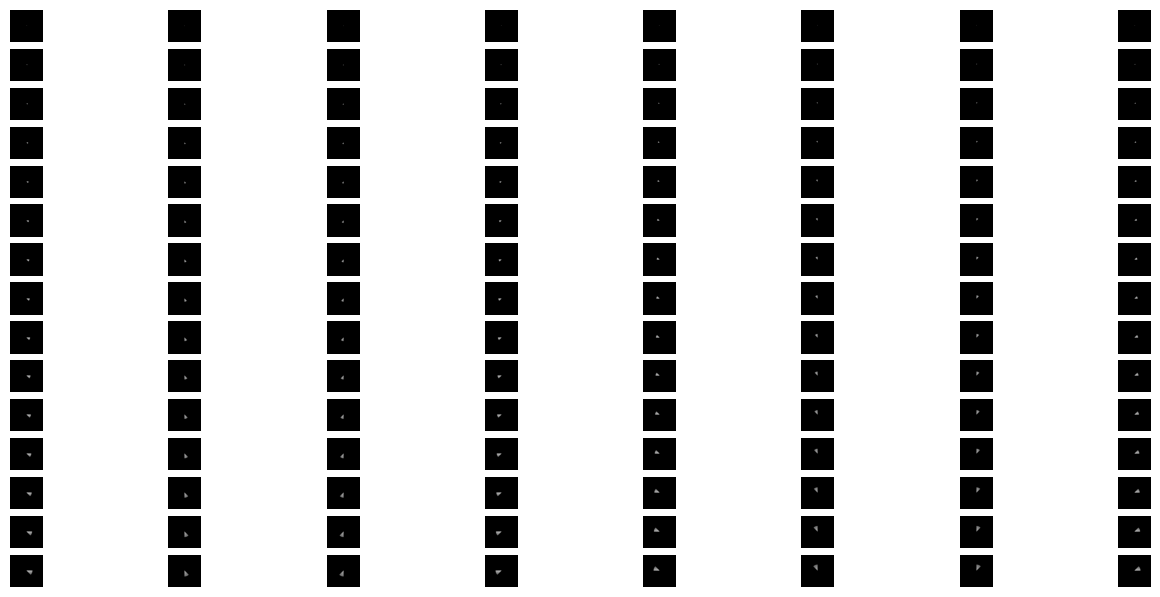

Image 1 :  [0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4] 159


In [ ]:
tsp1, tbp1, th1 = analyze_coefficients(image1)
print("Image 1 : ",tsp1,tbp1,th1)

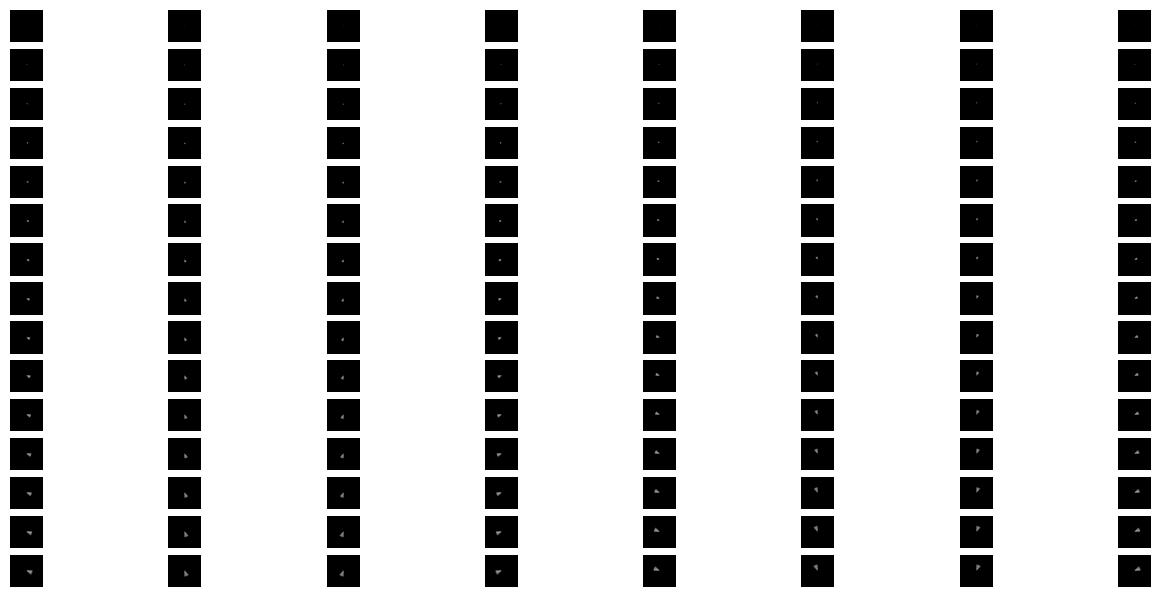

Image 2 :  [0, 8, 8, 8, 8, 8, 8, 8, 8, 6, 4, 4, 4, 4, 4, 4] [0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 4, 4, 4, 4, 4] 164


In [ ]:
tsp2, tbp2, th2 = analyze_coefficients(image2)
print("Image 2 : ",tsp2, tbp2,th2)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_tsp_tbp(TSP,TBP):
    x_values = np.arange(len(TSP))

    bar_width = 0.35
    plt.figure(figsize=(8, 6))  # Adjust width and height as needed
    plt.bar(x_values - bar_width/2, TSP, bar_width, label='Bright', color='green')
    plt.bar(x_values + bar_width/2, TBP, bar_width, label='Blur', color='red')
    plt.xlabel('Track Number')
    plt.ylabel('Number of Patches')
    plt.xticks(x_values, [i+1 for i in range(len(TSP))])  # Set x-axis labels
    plt.legend()
    plt.show()


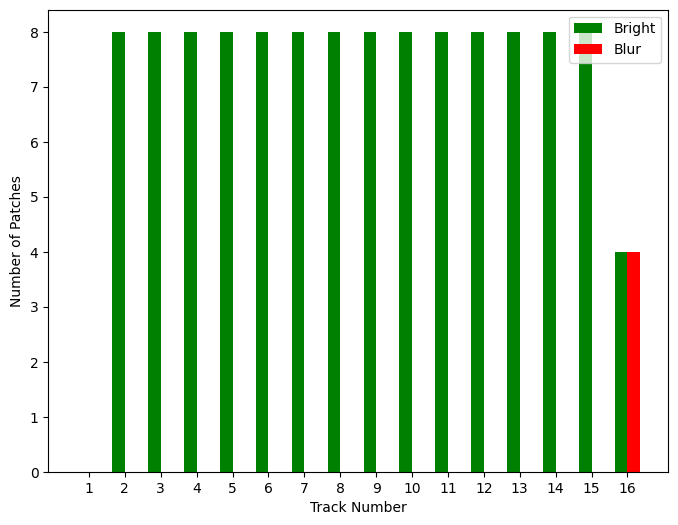

In [ ]:
plot_tsp_tbp(tsp1,tbp1)

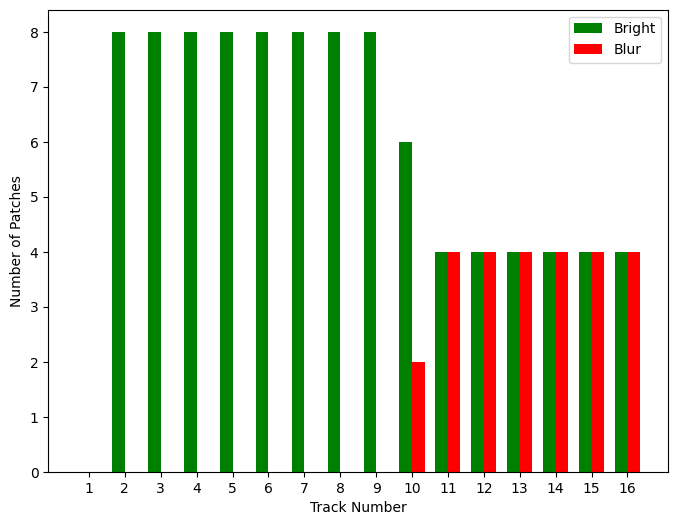

In [ ]:
plot_tsp_tbp(tsp2,tbp2)

### feature vector 1

In [ ]:
def fv1(tsp,tbp):
  new_arr = np.array([tsp,tbp])
  mean = np.mean(new_arr)
  print(mean)
  median = np.median(new_arr)
  print(median)
  s1 = np.std(tsp-mean)
  s2 = np.std(tbp-mean)
  s3 = np.std(tsp-median)
  s4 = np.std(tbp-median)

  return s1, s2, s3, s4

In [ ]:
img1_fv1 = fv1(tsp1,tbp1)
print(img1_fv1)

3.75
2.0
(2.1065374432940898, 0.9682458365518543, 2.1065374432940898, 0.9682458365518543)


In [ ]:
img2_fv1 = fv1(tsp2,tbp2)
print(img2_fv1)

3.75
4.0
(2.394655507583502, 1.899835519196333, 2.394655507583502, 1.899835519196333)


### feature vector 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def max_min_cluster(tsp, tbp):
    # Given list of data
    data = np.array([tsp, tbp])
    X = data.reshape(-1, 1)

    # Perform k-means clustering with k = 2
    kmeans = KMeans(n_clusters=2, random_state=0, n_init=10).fit(X)
    labels = kmeans.labels_

    # Store both clusters
    min_cluster = X[labels == 0].flatten()
    max_cluster = X[labels == 1].flatten()

    return max_cluster, min_cluster

print(max_min_cluster(tsp1,tbp1))
print(max_min_cluster(tsp2,tbp2))


(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 4]))
(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]), array([8, 8, 8, 8, 8, 8, 8, 8, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]))


In [ ]:
def fv2(tsp,tbp):
  max_c,min_c = max_min_cluster(tsp,tbp)
  f1 = np.mean(max_c)
  f2 = np.mean(min_c)
  f3 = np.std(max_c)
  f4 = np.std(min_c)

  return f1, f2, f3, f4



In [ ]:
img1_fv2 = fv2(tsp1,tbp1)
print(img1_fv2)

(0.0, 7.5, 0.0, 1.3228756555322954)


In [ ]:
img2_fv2 = fv2(tsp2,tbp2)
print(img2_fv2)

(0.18181818181818182, 5.619047619047619, 0.5749595745760689, 1.914262023070646)


[2.10653744 0.96824584 2.10653744 0.96824584 0.         7.5
 0.         1.32287566]
[2.39465551 1.89983552 2.39465551 1.89983552 0.18181818 5.61904762
 0.57495957 1.91426202]
[0.28087 0.1291  0.28087 0.1291  0.      1.      0.      0.17638]
[0.40698 0.31597 0.40698 0.31597 0.      1.      0.07231 0.31863]


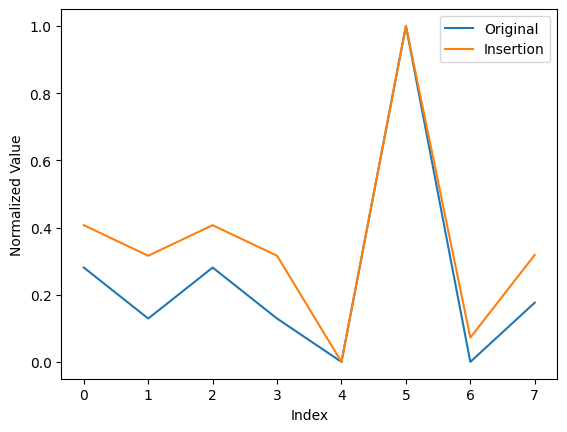

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming img1_fv1, img1_fv2, img2_fv1, img2_fv2 are defined

# Normalize the feature vectors to [0, 1]
import numpy as np

def normalize_feature_vectors(fv):
    min_val = np.min(fv)
    max_val = np.max(fv)
    normalized_fv = (fv - min_val) / (max_val - min_val)
    # Round the values to five decimal places
    normalized_fv_rounded = np.round(normalized_fv, decimals=5)
    return normalized_fv_rounded


# Create array fv_img1 containing all 8 values
fv_img1 = np.concatenate((img1_fv1, img1_fv2))
fv_img2 = np.concatenate((img2_fv1, img2_fv2))
print(fv_img1)
print(fv_img2)
# Normalize feature vector
fv_img1_normalized = normalize_feature_vectors(fv_img1)
fv_img2_normalized = normalize_feature_vectors(fv_img2)
print(fv_img1_normalized)
print(fv_img2_normalized)

# Plot
x = np.arange(len(fv_img1))  # Assuming all feature vectors have the same length
plt.plot(x, fv_img1_normalized, label='Original')
plt.plot(x, fv_img2_normalized, label='Insertion')
plt.xlabel('Index')
plt.ylabel('Normalized Value')
plt.legend()
plt.show()


### feature vector 3

In [ ]:
from sklearn.decomposition import PCA

def find_reference_angle(binary_spectrum):
    # Perform PCA to find the principal axis
    pca = PCA(n_components=1)
    pca.fit(binary_spectrum)

    # Get the eigenvectors
    eigenvectors = pca.components_

    # The first eigenvector represents the principal axis
    principal_axis_vector = eigenvectors[0]

    # Compute the angle of the principal axis with respect to the vertical axis (y-axis)
    reference_angle = np.arctan2(principal_axis_vector[0], principal_axis_vector[0]) * 180 / np.pi

    return reference_angle



In [ ]:
RA = find_reference_angle(bs1)
print(RA)

45.0


In [ ]:
def fv3(img):
  sector_masks = get_sector_mask(img,80)
  f_transform = np.fft.fft2(img)
  # Shift the zero frequency component to the center
  f_transform_shifted = np.fft.fftshift(f_transform)

  # Compute the magnitude spectrum
  magnitude_spectrum = np.int32(20 * np.log(np.abs(f_transform_shifted)))
  threshold = (np.max(magnitude_spectrum)+np.min(magnitude_spectrum))//2
  binary_spectrum = magnitude_spectrum > threshold
  binary_spectrum = binary_spectrum.astype(np.uint8) * 255
  RA = find_reference_angle(binary_spectrum)
  sector_vals = []
  for sector_mask in sector_masks:
    val = binary_spectrum.copy()
    val[sector_mask == 0] = 0
    sector_vals.append(val)

  CA = []
  for sector_val in sector_vals:
    if len(CA) == 0:
      CA.append(find_reference_angle(sector_val))
    else:
      CA.append(find_reference_angle(sector_val)+CA[-1])

  DA = []
  for x in CA:
    DA.append(abs(x-RA))

  return DA




In [ ]:
img1_fv3 = fv3(image1)
print(img1_fv3)

[180.0, 315.0, 270.0, 405.0, 360.0, 495.0, 450.0, 405.0]


In [ ]:
img2_fv3 = fv3(image2)
print(img2_fv3)

[180.0, 135.0, 90.0, 225.0, 360.0, 315.0, 450.0, 585.0]


[  2.10653744   0.96824584   2.10653744   0.96824584   0.
   7.5          0.           1.32287566 180.         315.
 270.         405.         360.         495.         450.
 405.        ]
[2.39465551e+00 1.89983552e+00 2.39465551e+00 1.89983552e+00
 1.81818182e-01 5.61904762e+00 5.74959575e-01 1.91426202e+00
 1.80000000e+02 1.35000000e+02 9.00000000e+01 2.25000000e+02
 3.60000000e+02 3.15000000e+02 4.50000000e+02 5.85000000e+02]
[0.00426 0.00196 0.00426 0.00196 0.      0.01515 0.      0.00267 0.36364
 0.63636 0.54545 0.81818 0.72727 1.      0.90909 0.81818]
[3.7800e-03 2.9400e-03 3.7800e-03 2.9400e-03 0.0000e+00 9.3000e-03
 6.7000e-04 2.9600e-03 3.0748e-01 2.3053e-01 1.5358e-01 3.8442e-01
 6.1527e-01 5.3832e-01 7.6916e-01 1.0000e+00]


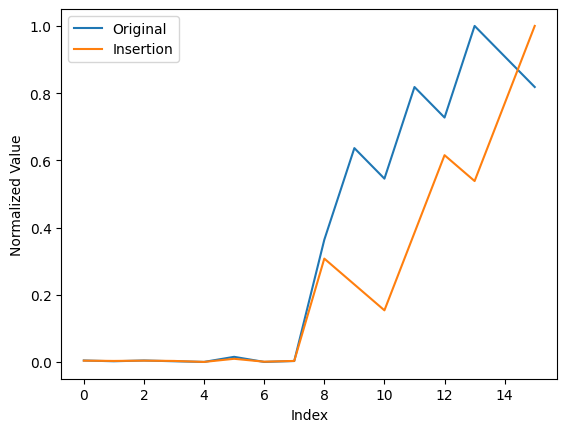

In [ ]:
# Create array fv_img1 containing all 8 values
fv_img1 = np.concatenate((img1_fv1, img1_fv2, img1_fv3))
fv_img2 = np.concatenate((img2_fv1, img2_fv2, img2_fv3))
print(fv_img1)
print(fv_img2)
# Normalize feature vector
fv_img1_normalized = normalize_feature_vectors(fv_img1)
fv_img2_normalized = normalize_feature_vectors(fv_img2)
print(fv_img1_normalized)
print(fv_img2_normalized)

# Plot
x = np.arange(len(fv_img1))  # Assuming all feature vectors have the same length
plt.plot(x, fv_img1_normalized, label='Original')
plt.plot(x, fv_img2_normalized, label='Insertion')
plt.xlabel('Index')
plt.ylabel('Normalized Value')
plt.legend()
plt.show()

### Feature vector 4

In [ ]:
def fv4(img):
  track_masks = get_circular_track_mask(img)
  f_transform = np.fft.fft2(img)
  # Shift the zero frequency component to the center
  f_transform_shifted = np.fft.fftshift(f_transform)

  # Compute the magnitude spectrum
  magnitude_spectrum = np.int32(20 * np.log(np.abs(f_transform_shifted)))
  threshold = (np.max(magnitude_spectrum)+np.min(magnitude_spectrum))//2
  binary_spectrum = magnitude_spectrum > threshold
  binary_spectrum = binary_spectrum.astype(np.uint8) * 255
  RA = find_reference_angle(binary_spectrum)
  track_vals = []
  for track_mask in track_masks:
    val = binary_spectrum.copy()
    val[track_mask == 0] = 0
    track_vals.append(val)

  CA = []
  for track_val in track_vals:
    if len(CA) == 0:
      CA.append(find_reference_angle(track_val))
    else:
      CA.append(find_reference_angle(track_val)+CA[-1])

  DA = []
  for x in CA:
    DA.append(abs(x-RA))

  return DA


In [ ]:
img1_fv4 = fv4(image1)
print(img1_fv4)

[0.0, 45.0, 90.0, 225.0, 360.0, 495.0, 630.0, 765.0, 720.0, 675.0, 810.0, 945.0, 900.0, 855.0, 990.0, 1125.0]


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: divide by zero encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


In [ ]:
img2_fv4 = fv4(image2)
print(img2_fv4)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: divide by zero encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


[0.0, 45.0, 90.0, 135.0, 0.0, 45.0, 90.0, 225.0, 360.0, 495.0, 630.0, 765.0, 720.0, 675.0, 630.0, 765.0]


## combine the feature vectors

[2.10653744e+00 9.68245837e-01 2.10653744e+00 9.68245837e-01
 0.00000000e+00 7.50000000e+00 0.00000000e+00 1.32287566e+00
 1.80000000e+02 3.15000000e+02 2.70000000e+02 4.05000000e+02
 3.60000000e+02 4.95000000e+02 4.50000000e+02 4.05000000e+02
 0.00000000e+00 4.50000000e+01 9.00000000e+01 2.25000000e+02
 3.60000000e+02 4.95000000e+02 6.30000000e+02 7.65000000e+02
 7.20000000e+02 6.75000000e+02 8.10000000e+02 9.45000000e+02
 9.00000000e+02 8.55000000e+02 9.90000000e+02 1.12500000e+03]
[2.39465551e+00 1.89983552e+00 2.39465551e+00 1.89983552e+00
 1.81818182e-01 5.61904762e+00 5.74959575e-01 1.91426202e+00
 1.80000000e+02 1.35000000e+02 9.00000000e+01 2.25000000e+02
 3.60000000e+02 3.15000000e+02 4.50000000e+02 5.85000000e+02
 0.00000000e+00 4.50000000e+01 9.00000000e+01 1.35000000e+02
 0.00000000e+00 4.50000000e+01 9.00000000e+01 2.25000000e+02
 3.60000000e+02 4.95000000e+02 6.30000000e+02 7.65000000e+02
 7.20000000e+02 6.75000000e+02 6.30000000e+02 7.65000000e+02]
[1.87e-03 8.60e-04 1.8

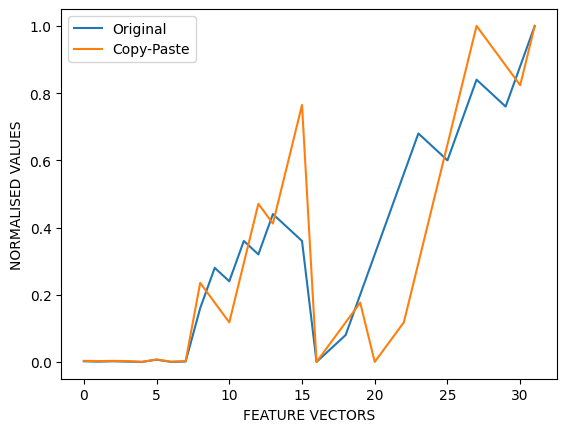

In [ ]:
# Create array fv_img1 containing all 8 values
fv_img1 = np.concatenate((img1_fv1, img1_fv2, img1_fv3,img1_fv4))
fv_img2 = np.concatenate((img2_fv1, img2_fv2, img2_fv3,img2_fv4))
print(fv_img1)
print(fv_img2)
# Normalize feature vector
fv_img1_normalized = normalize_feature_vectors(fv_img1)
fv_img2_normalized = normalize_feature_vectors(fv_img2)
print(fv_img1_normalized)
print(fv_img2_normalized)

# Plot
x = np.arange(len(fv_img1))  # Assuming all feature vectors have the same length
plt.plot(x, fv_img1_normalized, label='Original')
plt.plot(x, fv_img2_normalized, label='Copy-Paste')
plt.xlabel('FEATURE VECTORS')
plt.ylabel('NORMALISED VALUES')
plt.legend()
plt.show()

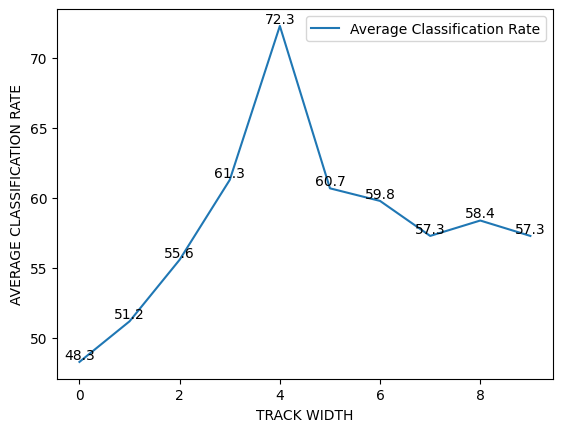

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fv = [48.3, 51.2, 55.6, 61.3, 72.3, 60.7, 59.8, 57.3, 58.4, 57.3]
x = np.arange(10)  # Assuming all feature vectors have the same length

plt.plot(x, fv, label='Average Classification Rate')
plt.xlabel('TRACK WIDTH')
plt.ylabel('AVERAGE CLASSIFICATION RATE')
plt.legend()

for i, rate in enumerate(fv):
    plt.text(x[i], rate, str(rate), ha='center', va='bottom')

plt.show()


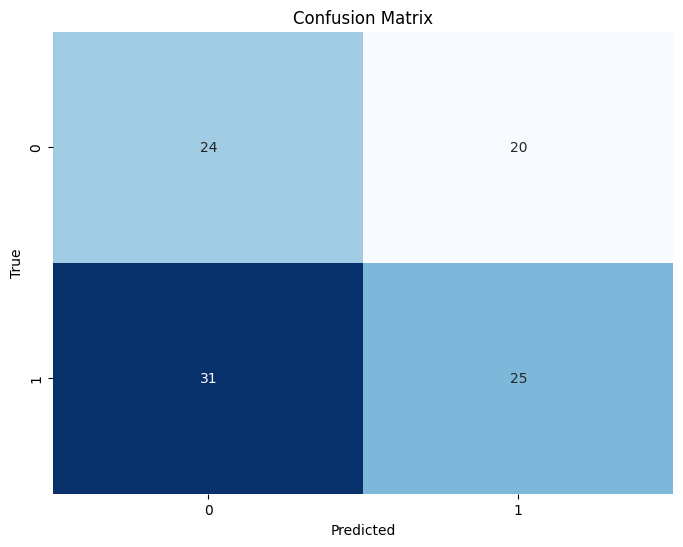

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate random ground truth and predictions for demonstration
np.random.seed(0)
y_true = np.random.randint(0, 2, size=100)  # Binary classification
y_pred = np.random.randint(0, 2, size=100)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define the neural network architecture
model = Sequential([
    Dense(64, input_shape=(32,), activation='relu'),  # 64 neurons, ReLU activation
    Dense(128, activation='relu'),  # 128 neurons, ReLU activation
    Dense(512, activation='relu'),  # 512 neurons, ReLU activation
    Dense(256, activation='relu'),  # 256 neurons, ReLU activation
    Dense(64, activation='relu'),  # 64 neurons, ReLU activation
    Dense(10, activation='relu'),  # 10 neurons, ReLU activation
    Dense(1, activation='sigmoid')  # Output layer with 1 neuron, sigmoid activation for binary classification
])

# Compile the model with specified optimizer and learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 512)               66048     
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dense_4 (Dense)             (None, 64)                16448     
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
 dense_6 (Dense)             (None, 1)                 1